In [4]:
import sys
import time
import pandas as pd
from sklearn import model_selection
from sklearn import ensemble, linear_model, svm, metrics, cluster, tree
from xgboost import XGBRegressor
from matplotlib import pyplot as plt
import scipy
import os
import numpy as np
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import preprocessing
from sklearn.feature_selection import *
from sklearn.model_selection import GridSearchCV, KFold

start_time = time.time()

n_cv = 5
n_jobs = 4
random_state = 3111696
d_set = "data/Erlotinib.csv"

print("Loading dataset: %s" % d_set)
df = pd.read_csv("depmap/" + d_set, sep=",")
columns = list(df.columns.values)
label = df[columns[-1]].copy()
data = df.drop(columns[-1], axis=1)
print(data.shape)
print(label.shape)
print("Dataset loaded")

Loading dataset: data/Erlotinib.csv
(370, 17738)
(370,)
Dataset loaded


In [5]:
print('Feature extraction started...')

clf = XGBRegressor(n_estimators=100, random_state=random_state)
clf = clf.fit(data, label)
model = SelectFromModel(clf, prefit=True)
extracted_features_data = model.transform(data)

print("Size low dimensional data: ", extracted_features_data.shape)
print('Feature extraction finished')

Feature extraction started...
Size low dimensional data:  (370, 473)
Feature extraction finished


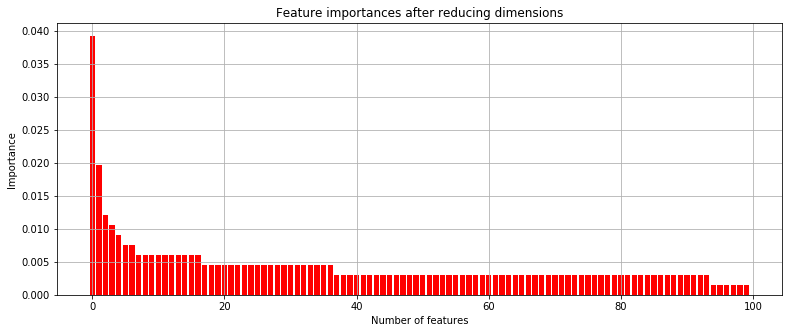

Size low dimensional data:  (370, 100)
Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  46 tasks      | elapsed:    7.8s
[Parallel(n_jobs=4)]: Done 196 tasks      | elapsed:   33.8s


{'regression_ld__colsample_bytree': 0.4, 'regression_ld__max_depth': 2, 'regression_ld__n_estimators': 200, 'regression_ld__subsample': 0.5}
0.53
Total time taken: 148 seconds


[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:   58.5s finished


In [7]:
f_importances = clf.feature_importances_
indices_ld = np.argsort(f_importances)[::-1]
topk = 100

indices_ld = indices_ld[:topk]

plt.figure(figsize=(13, 5))
plt.title("Feature importances after reducing dimensions")
plt.bar(range(topk), f_importances[indices_ld], color="r")
plt.xlabel("Number of features")
plt.ylabel("Importance")
plt.grid(True)
plt.show()

new_data = np.zeros([data.shape[0], topk])
for idx in range(topk):
    new_data[:, idx] = data.iloc[:, indices_ld[idx]].values
print("Size low dimensional data: ", new_data.shape)

pipe_regressor_ld = Pipeline([
  ('regression_ld', XGBRegressor(random_state=random_state))
])

parameters_ld = [
    {   
        'regression_ld__max_depth': [2, 3, 4, 5, 6],
        'regression_ld__subsample': [0.7, 0.6, 0.5, 0.4],
        'regression_ld__colsample_bytree': [0.7, 0.6, 0.5, 0.4],
        'regression_ld__n_estimators': [200]
    }
]

optimized_regressor_ld = GridSearchCV(pipe_regressor_ld, parameters_ld, \
                                       cv=KFold(n_splits=n_cv, shuffle=True, random_state=random_state), \
                                       error_score=0, scoring='r2', verbose=True, n_jobs=n_jobs, \
                                       pre_dispatch="1*n_jobs")

optimized_regressor_ld.fit(new_data, label)
best_regressor_ld = optimized_regressor_ld.best_estimator_
best_result_ld = optimized_regressor_ld.cv_results_

print(optimized_regressor_ld.best_params_)
best_score_ld = optimized_regressor_ld.best_score_
print(np.round(best_score_ld, 2))

end_time = time.time()
print('Total time taken: %d seconds' % int(end_time - start_time))